---

# KDDCUP99_INV

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn

from time import time
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, average_precision_score,auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle

import pandas as pd
import os
import sys

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')

from load_data import get_KDDCUP99_INV
from FGAN_MODEL import FenceGAN

In [2]:
def meanAUC_PRAUC(auc_list, pr_list, name, SPACE_AUC, SPACE_AUPRC):
    print('AUC:')
    print(auc_list)
    print('**************')
    print('PR AUC:')
    print(pr_list)
    print('**************')
    
    
    AUC_Frame = pd.DataFrame(auc_list, columns = [name])
    PR_AUC_Frame = pd.DataFrame(pr_list, columns = [name])
    
    AU_NAME = f'{name}.csv'
    
    AUC_Frame.to_csv(os.path.join(SPACE_AUC, AU_NAME), index=False)
    PR_AUC_Frame.to_csv(os.path.join(SPACE_AUPRC, AU_NAME), index=False)
    
    AUC_Frame = list(AUC_Frame[name])

    N = len(AUC_Frame)
    mean_auc = np.mean(AUC_Frame)
    std_auc = np.std(AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')
    print('**************')
    
    PR_AUC_Frame = list(PR_AUC_Frame[name])

    N = len(PR_AUC_Frame)
    mean_auc = np.mean(PR_AUC_Frame)
    std_auc = np.std(PR_AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('PR AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')

In [6]:
batch_size = 1024

WORK_SPACE = '../Dataset'
FILE = 'kddcup.data_10_percent_corrected'

SPACE_MODELS = './models'
SPACE_AUC = './auc'
SPACE_AUPRC = './auprc'

for n in (SPACE_MODELS, SPACE_AUC, SPACE_AUPRC):
    if not os.path.exists(n):
        os.mkdir(n)
        
DATASET = 'KDDCUP99_INV'

PATH = os.path.join(WORK_SPACE, FILE)

In [4]:
dataset = get_KDDCUP99_INV(PATH, seed, show=True)

396743 normal records, 97278 anormal records
We use 48640 anomalous records
-----------------------------------------------------------------------------------------
There are 274006 records in training set
Training set is composed by 274006 normal records and 0 abnormal records
-----------------------------------------------------------------------------------------
There are 43701 records in validation set
Validation set is composed by 31540 normal records and 12161 abnormal records
-----------------------------------------------------------------------------------------
There are 127676 records in test set
Test set is composed by 91197 normal records and 36479 abnormal records


In [5]:
nc = dataset['x_train'].shape[1]
z_dim = 32
gamma = 0.1
alpha = 0.5 
beta = 30 
_power = 2
v_freq = 4

g_objective_anneal = 1
repeat = 4 
baseline = 0.5

#### Mean AUC and standard deviation after seven runs

Iteration: 1
Epoch #1: Loss: 0.7640
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.128 | g_loss: 1.8441
[INFO] Training phase... Elapsed time: 1911 seconds



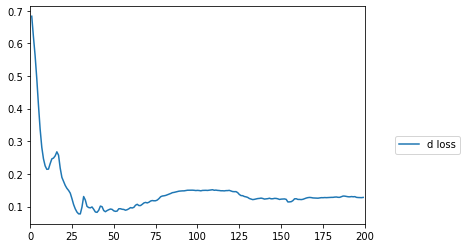

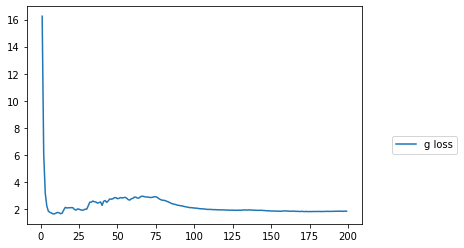

PR AUC: 0.87


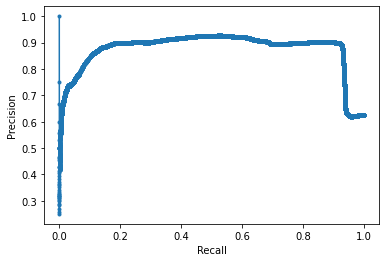

AUC: 0.97
Iteration: 2
Epoch #1: Loss: 0.7229
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.120 | g_loss: 1.7422
[INFO] Training phase... Elapsed time: 1984 seconds



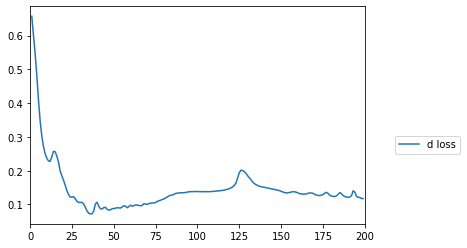

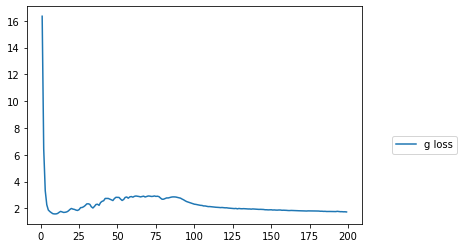

PR AUC: 0.71


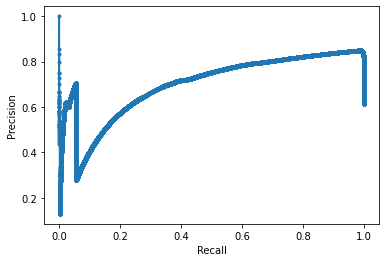

AUC: 0.94
Iteration: 3
Epoch #1: Loss: 0.7139
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.113 | g_loss: 1.7686
[INFO] Training phase... Elapsed time: 1973 seconds



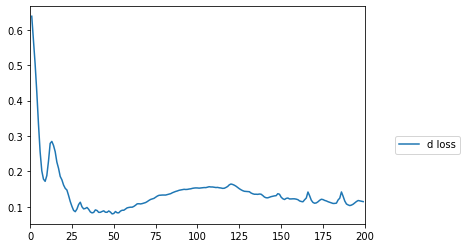

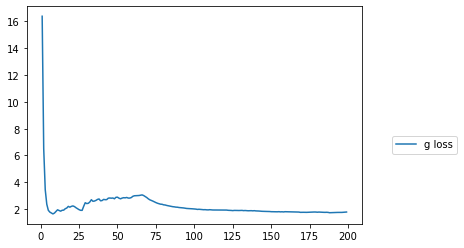

PR AUC: 0.70


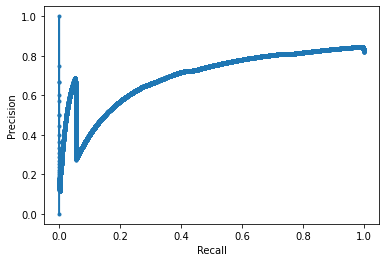

AUC: 0.94
Iteration: 4
Epoch #1: Loss: 0.6928
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.121 | g_loss: 1.7585
[INFO] Training phase... Elapsed time: 2019 seconds



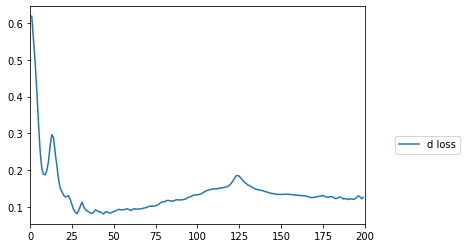

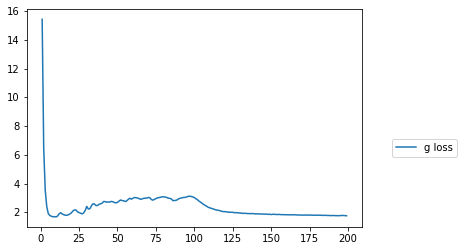

PR AUC: 0.73


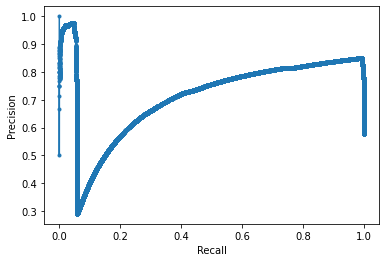

AUC: 0.94
Iteration: 5
Epoch #1: Loss: 0.6945
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.121 | g_loss: 1.7544
[INFO] Training phase... Elapsed time: 1974 seconds



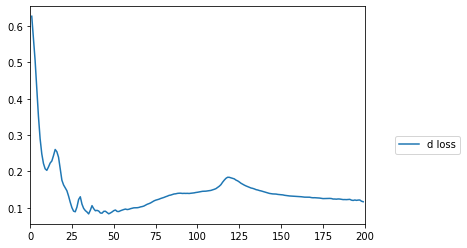

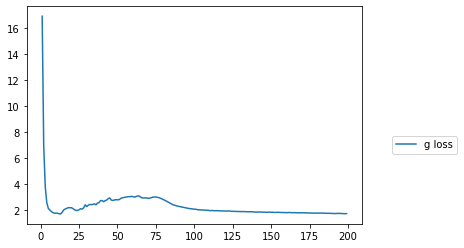

PR AUC: 0.73


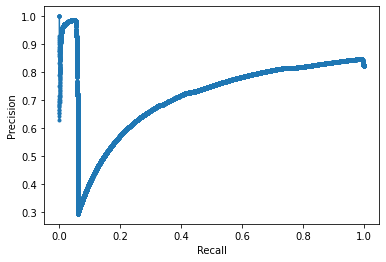

AUC: 0.94
Iteration: 6
Epoch #1: Loss: 0.7339
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.108 | g_loss: 1.7625
[INFO] Training phase... Elapsed time: 1748 seconds



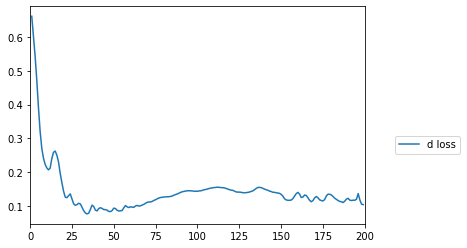

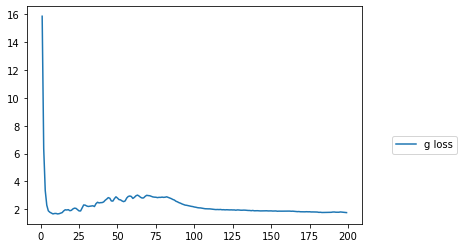

PR AUC: 0.88


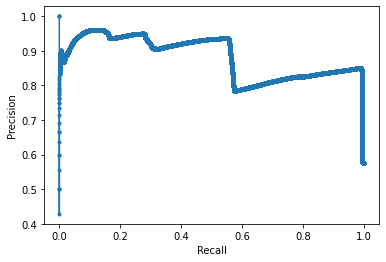

AUC: 0.97
Iteration: 7
Epoch #1: Loss: 0.7132
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.123 | g_loss: 2.0960
[INFO] Training phase... Elapsed time: 1726 seconds



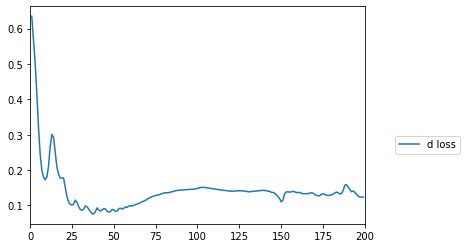

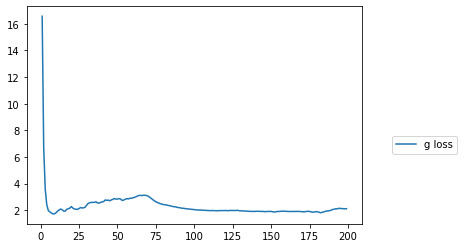

PR AUC: 0.94


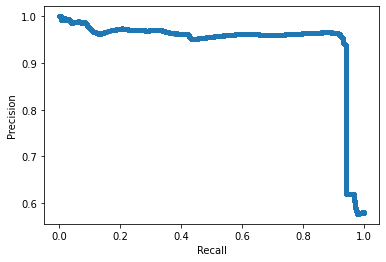

AUC: 0.98
Iteration: 8
Epoch #1: Loss: 0.7106
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.127 | g_loss: 1.8968
[INFO] Training phase... Elapsed time: 1537 seconds



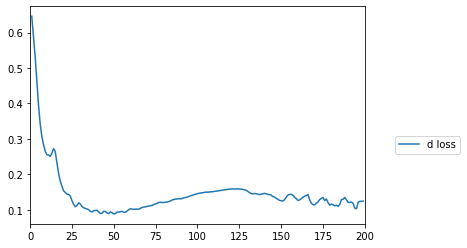

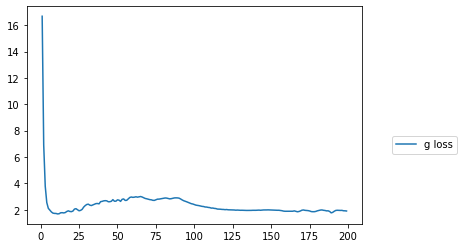

PR AUC: 0.97


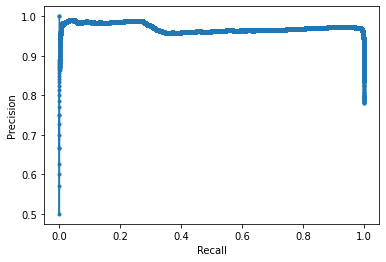

AUC: 0.99
Iteration: 9
Epoch #1: Loss: 0.7181
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.122 | g_loss: 1.8547
[INFO] Training phase... Elapsed time: 1455 seconds



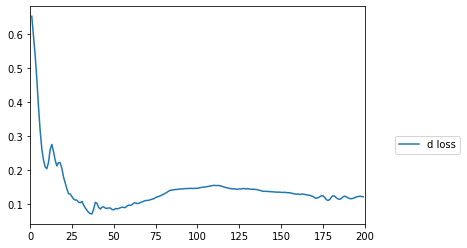

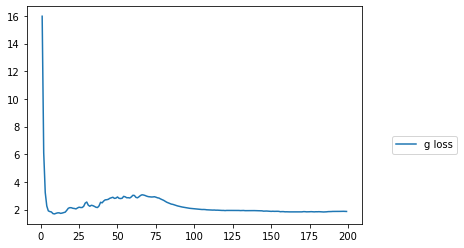

PR AUC: 0.43


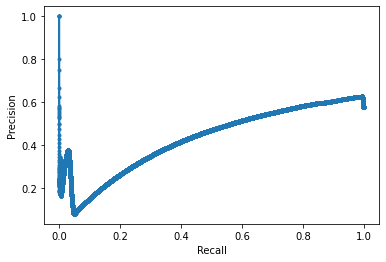

AUC: 0.78
Iteration: 10
Epoch #1: Loss: 0.7264
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.118 | g_loss: 1.7447
[INFO] Training phase... Elapsed time: 1442 seconds



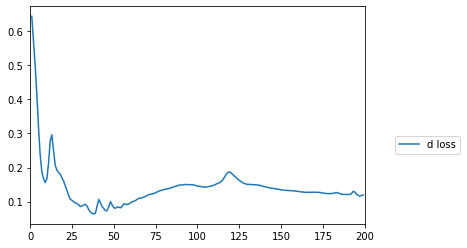

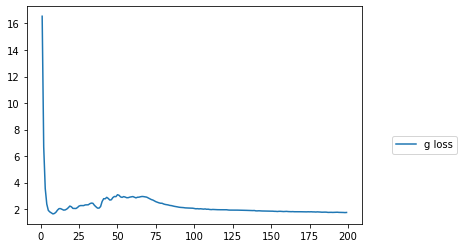

PR AUC: 0.73


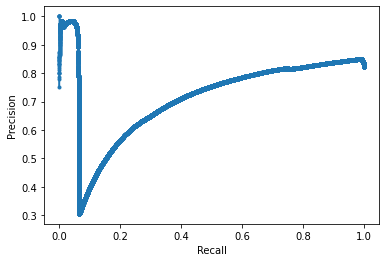

AUC: 0.94
Iteration: 11
Epoch #1: Loss: 0.7513
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.122 | g_loss: 1.7865
[INFO] Training phase... Elapsed time: 1686 seconds



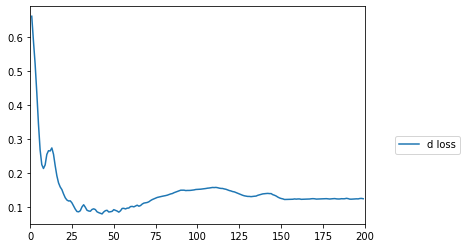

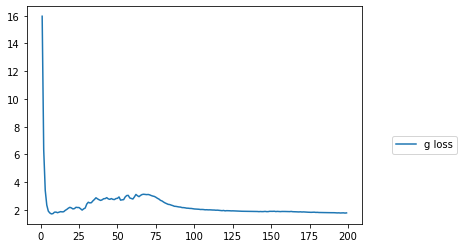

PR AUC: 0.42


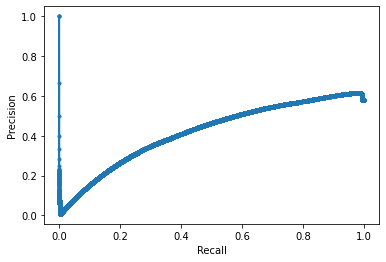

AUC: 0.77
Iteration: 12
Epoch #1: Loss: 0.7380
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.125 | g_loss: 1.8352
[INFO] Training phase... Elapsed time: 1697 seconds



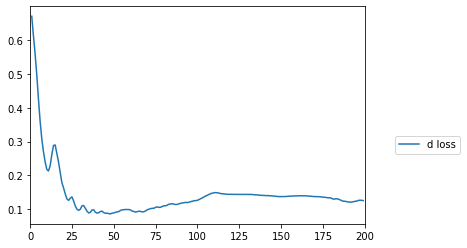

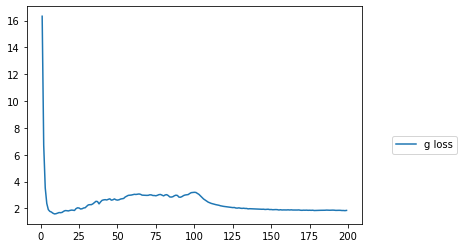

PR AUC: 0.42


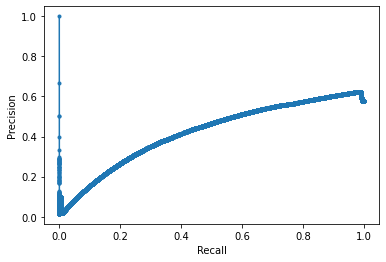

AUC: 0.77
Iteration: 13
Epoch #1: Loss: 0.7265
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.119 | g_loss: 1.9202
[INFO] Training phase... Elapsed time: 1788 seconds



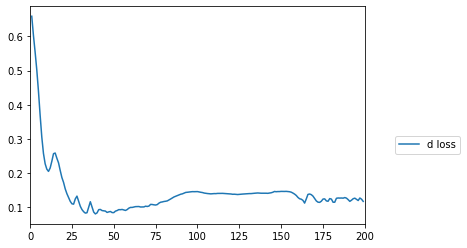

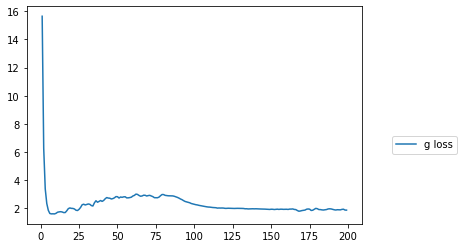

PR AUC: 0.96


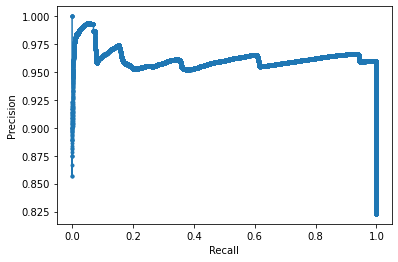

AUC: 0.99
Iteration: 14
Epoch #1: Loss: 0.6693
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.108 | g_loss: 1.7383
[INFO] Training phase... Elapsed time: 2612 seconds



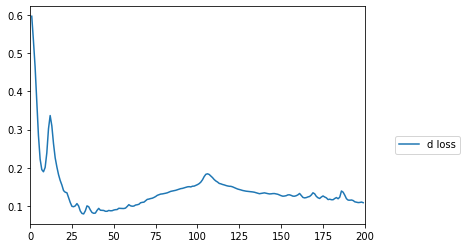

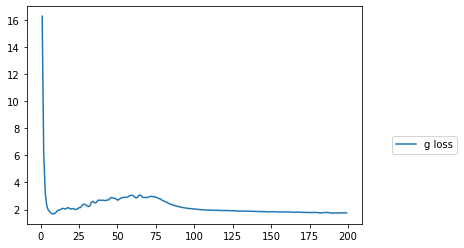

PR AUC: 0.72


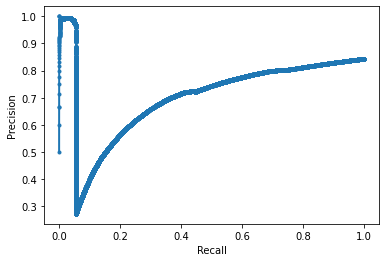

AUC: 0.94
Iteration: 15
Epoch #1: Loss: 0.7146
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.107 | g_loss: 1.8467
[INFO] Training phase... Elapsed time: 2668 seconds



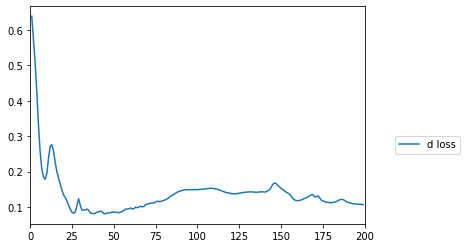

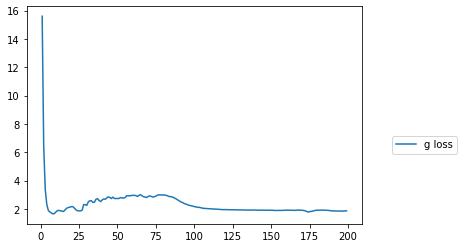

PR AUC: 0.73


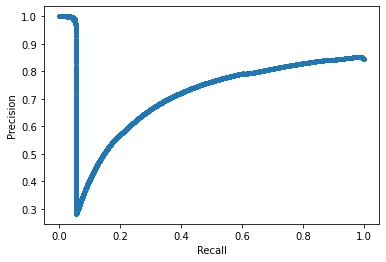

AUC: 0.94
Iteration: 16
Epoch #1: Loss: 0.7643
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.107 | g_loss: 1.7442
[INFO] Training phase... Elapsed time: 2674 seconds



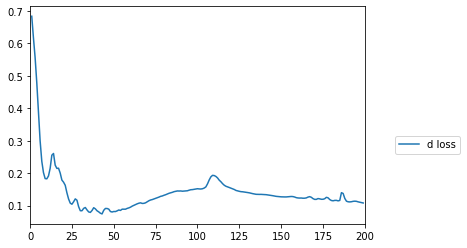

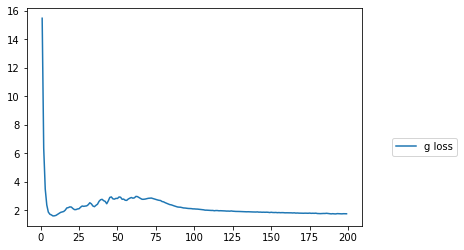

PR AUC: 0.73


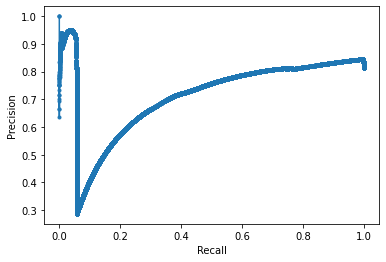

AUC: 0.94
Iteration: 17
Epoch #1: Loss: 0.7444
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.117 | g_loss: 1.7738
[INFO] Training phase... Elapsed time: 2844 seconds



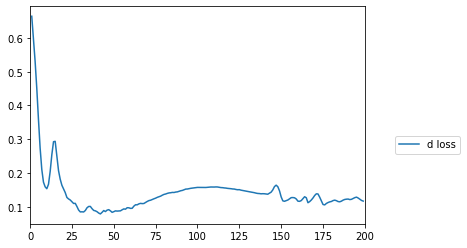

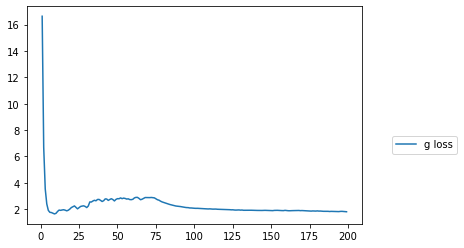

PR AUC: 0.96


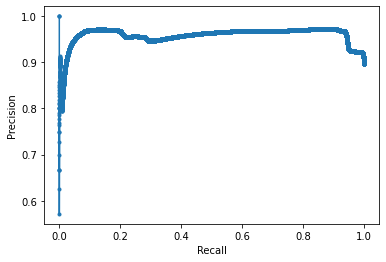

AUC: 0.99
Iteration: 18
Epoch #1: Loss: 0.7178
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.131 | g_loss: 1.8567
[INFO] Training phase... Elapsed time: 2897 seconds



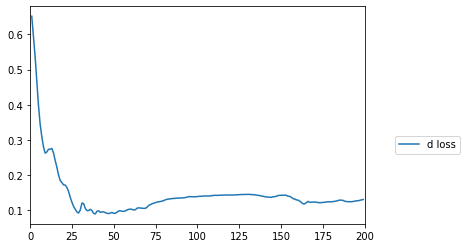

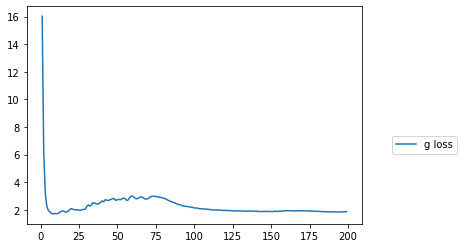

PR AUC: 0.42


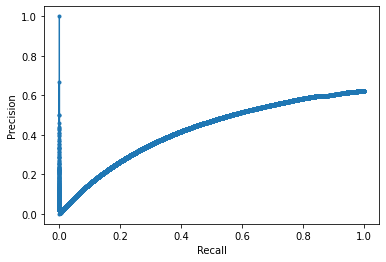

AUC: 0.77
Iteration: 19
Epoch #1: Loss: 0.7086
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.112 | g_loss: 1.8186
[INFO] Training phase... Elapsed time: 2888 seconds



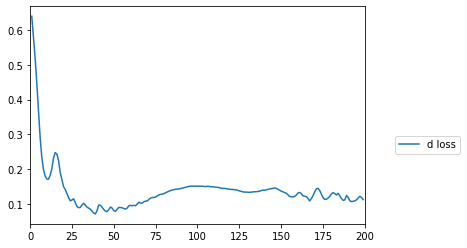

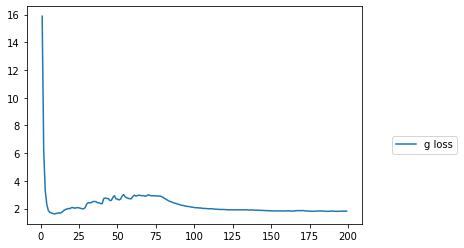

PR AUC: 0.71


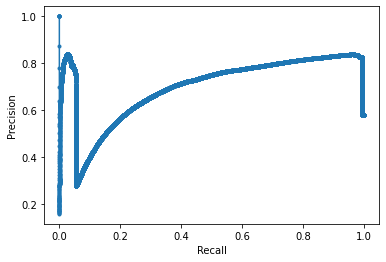

AUC: 0.93
Iteration: 20
Epoch #1: Loss: 0.7493
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.125 | g_loss: 1.7374
[INFO] Training phase... Elapsed time: 2801 seconds



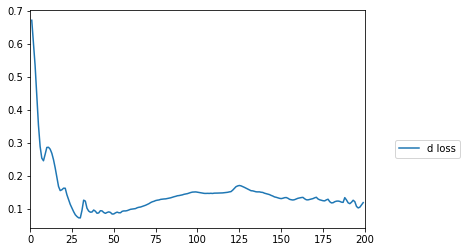

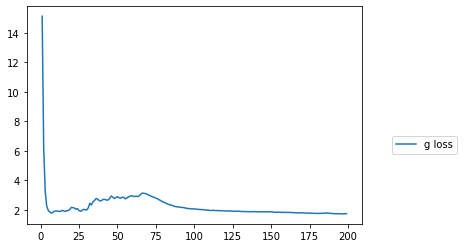

PR AUC: 0.70


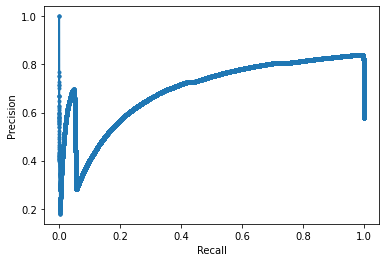

AUC: 0.94


In [8]:
n_runs = 20
auc_list = []
n_epochs = 200
seed = 42
pr_list = []

for i in range(n_runs):
    print(f'Iteration: {i+1}')
    dataset = get_KDDCUP99_INV(PATH, seed*(i+1), show=False)
    
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_train']).to(device), 
                                              torch.tensor(dataset['y_train'].to_numpy()).to(device))
    
    train_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True, drop_last = True)

    val_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_val']).to(device), 
                                              torch.tensor(dataset['y_val'].to_numpy()).to(device))
    val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle=False)

    test_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_test']).to(device), 
                                              torch.tensor(dataset['y_test'].to_numpy()).to(device))
    test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)
    
    trainer = FenceGAN(nc, z_dim, gamma, alpha, beta, _power, v_freq, g_objective_anneal, repeat, baseline, device)
    
    d_losses, g_losses = trainer.train(train_loader, test_loader, val_loader, batch_size, n_epochs)
    
    # Save models
    NAME_D = f'D_FGAN_{DATASET}_{i}.ckpt'
    NAME_G = f'G_FGAN_{DATASET}_{i}.ckpt'
    
    torch.save(trainer.D.state_dict(), os.path.join(SPACE_MODELS, NAME_D))
    torch.save(trainer.G.state_dict(), os.path.join(SPACE_MODELS, NAME_G))
    
    _auc, pr_auc = trainer.predict(test_loader)
    print(f'AUC: {_auc:.2f}')
    auc_list.append(_auc)
    pr_list.append(pr_auc)

In [9]:
meanAUC_PRAUC(auc_list, pr_list, 'FGAN_KDDCUP99_INV', SPACE_AUC, SPACE_AUPRC)

AUC:
[0.966741723162148, 0.9382082106335473, 0.9368136227838235, 0.9387433899906513, 0.9386976108251287, 0.9652120714890602, 0.9778341506552752, 0.9934417979516581, 0.7827304288293782, 0.9385360050834306, 0.7699205252891612, 0.7726060348367442, 0.9918258102718791, 0.9359983639508515, 0.9401905840373389, 0.9386272656787136, 0.9919544617296123, 0.7737245724877638, 0.9345184333986544, 0.9365078942963185]
**************
PR AUC:
[0.8715676432560782, 0.707126167777527, 0.6990152162505139, 0.7294368743189321, 0.731064808706884, 0.8825491565830266, 0.9444915317218463, 0.9711070402581502, 0.43438925430239766, 0.7326319155499007, 0.4190128288119121, 0.4211155693635404, 0.9620782730818406, 0.7229406035281991, 0.7342071038790264, 0.7280375682824011, 0.958699884276881, 0.42346467297502366, 0.7092225277062318, 0.7014102119753783]
**************
AUC
0.92 +/- 0.03
95% confidence level, average auc would be between 0.89 and 0.95
**************
PR AUC
0.72 +/- 0.08
95% confidence level, average auc woul

---